<a href="https://colab.research.google.com/github/liorot/IDC_NLP_Final_Project_2022/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.nn.modules import dropout
from google.colab import drive
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
drive.mount('/drive')
DIRECTORY = '/drive/MyDrive/Colab Notebooks/NLPFinalProject/mbti.csv'
data = pd.read_csv(DIRECTORY)

Mounted at /drive


In [4]:
RANDOM_SEED = 42
LABEL_COLUMNS = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4
PERSONALTIES_TYPE = {x:i for i,x in enumerate(set(data['type'].to_list()))}
data['label'] = data['type'].apply(lambda x: PERSONALTIES_TYPE[x])

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Preprocessing
Same as for the Bert Model

In [6]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

# method to clean the text
def clean_posts(text, drop_stop_words = True, drop_per_types=True):
    text = text.lower()
    # replacing ||| with space
    text = re.sub(r"\|\|\|", " ", text)

    text = re.sub('https?://\S+|www\.\S+', '', text) # remove url
    # this function remove emoji 
    text.encode('ascii', 'ignore').decode('ascii')

    # remove extra white spaces
    text = remove_extra_white_spaces(text)
    
    # tokenize the text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    if drop_per_types:
        text = [x for x in text if x.upper() not in PERSONALTIES_TYPE]
        
    if drop_stop_words:
        for word in stopwords.words('english'):
            if word in text:
                text.remove(word) 

    # remove empty/1 length words
    text = [t for t in text if len(t) > 1]
    
    # lemmatize
    clean_post = lemmatizing(" ".join(text))

    return clean_post

def encode_posts(text, vocab2index, max_text_length):
    tokenized = [token.text for token in tok.tokenizer(text)]
    encoded = np.zeros(max_text_length, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(max_text_length, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded

In [7]:
data['posts'] = data['posts'].apply(clean_posts)

# Vocab

We need to convert our text into a numerical form that can be fed to our model as input. we have used spacy for tokenization after cleaning the data.
We first want to build a vocbulary so we count the number of occurrences of each token in our corpus and choose the top freqeunt words 

We then create a vocabulary to index mapping and encode our posts using this mapping.

In [8]:
#tokenization
tok = spacy.load("en_core_web_sm")

#count number of occurences of each word
max_tokens = 0
sum_num = 0
counts = Counter()
for index, row in data.iterrows():
    posts = row['posts']
    tokens = [token.text for token in tok.tokenizer(posts)]
    max_tokens = max(len(tokens), max_tokens)
    sum_num += len(tokens)
    counts.update(tokens)
print(f"max number of tokens: {max_tokens}")
print(f"average number of tokens: {sum_num/len(data)}")

max number of tokens: 1750
average number of tokens: 1131.9897406340058


As we can see, the averge number of tokens for each user is ~1000 tokens.
After trying diffrent values between 300-1000 we found that the max text length that brings better results is 700.
Also, we check for diffrent values for the vocab length, i.e how many freqent words to include and find the best value for this hyper paramter is 3000.

In [9]:
### Preprocessing variables
NUM_FREQ_WORDS = 3000
MAX_TEXT_LENGTH = 700

In [10]:
print("num_words before:",len(counts.keys()))
counts = dict(counts.most_common(NUM_FREQ_WORDS))
print("num_words before:",len(counts.keys()))

num_words before: 93126
num_words before: 3000


In [11]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

# Create Dataset

This function takes one of the [train, dev, test] and the vocab2index, and creating dataset for the model from shape of [(LongTensor, FloatTensor)] that corresponds to (user posts,labels) which each long tensor represent encoded posts of a user and each float tensor represent the labels for this user.

In [12]:
def create_dataset(data, vocab2index):
  data_sequences = []
  for index, row in data.iterrows():
    posts = row['posts']
    labels = [classes[p] for p in row["type"]]
    labels = np.array(labels, dtype="float32")
    if len(posts) > 1:
      encoded = torch.LongTensor(encode_posts(posts, vocab2index, MAX_TEXT_LENGTH))
      tags = torch.FloatTensor(labels)
      data_sequences.append((encoded, tags))
  return data_sequences

# Split to Train, Test, Validation

In [13]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)
print (f" train data size is: {len(df_train)}")
print (f" test data size is: {len(df_test)}")
print (f" val data size is: {len(df_val)}")

 train data size is: 6246
 test data size is: 1735
 val data size is: 694


In [14]:
train_sequences = create_dataset(df_train, vocab2index)
test_sequences = create_dataset(df_test, vocab2index)
val_sequences = create_dataset(df_val, vocab2index)

# Data Loader

Create the DataLoaders for our training set.

In [53]:
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler

# Use to balance the data
def get_train_sampler(df_train):
  labels=df_train['label']
  counts = np.bincount(labels)
  labels_weights = 1. / counts
  weights = labels_weights[labels]
  return WeightedRandomSampler(weights, len(weights))

#We'll take training samples in random order with weights to overcome data imbalance. 
train_dataloader = DataLoader(
            train_sequences,  # The training samples.
            sampler = get_train_sampler(df_train), # Select users randomly according to weights
        )

# Model
we have glove embedding, dropout layer to prevent overfitting, final linear layer with 4 outputs.


In [16]:
### Learning variables
LEARNING_RATE = 0.001
DROPOUT = 0.1
NUM_EPOCHS = 10
VOCAB_SIZE = len(words)
N_LAYERS = 2
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 500

MbtiLSTMNet, is a PyTorch Module for labeling user with personality prediction

input_size: the size of the vocabulary

embedding_size: the size of the embeddings

Embeddings - learned embedding.

hidden_size: the LSTM hidden size

output_size: the number tags we are predicting for

n_layers: the number of layers we want to use in LSTM

The input for the forward function is a tensor containing 700 tokens from the user post.

In [17]:
class MbtiLSTMNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers):
        super(MbtiLSTMNet, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True, dropout=DROPOUT)
        self.out = nn.Linear(hidden_size*n_layers, output_size)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
    
    def forward(self, input_post):
        post = self.embedding(input_post)
        lstm_output, (hn,cn) = self.lstm(post)
        output = self.out(hn.permute(1,0,2).view(1,-1))
        return output

## Training

In [18]:
def train_loop(model, n_epochs):
  """
  train loop for multilabel classification , https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/45
  """
  # Loss function
  criterion = nn.BCEWithLogitsLoss()

  # Optimizer (ADAM is a fancy version of SGD)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  for e in range(1, n_epochs + 1):
    print(f"Starting ephoch : {e}")
    for i, (post, labels) in enumerate(train_dataloader):
      if i%2000 == 0 and i!=0:
        print(f"Finish Training model on {i} users for epoch {e}")
      post_tensor = post.view(1,-1).to(device)
      labels_tensor = labels.to(device)
      optimizer.zero_grad()
      output_labels = model(post_tensor)
      criterion(output_labels,labels_tensor).backward()
      optimizer.step()
  
  return model

In [56]:
model = MbtiLSTMNet(input_size=VOCAB_SIZE, 
                   embedding_size=EMBEDDING_SIZE, 
                   hidden_size=HIDDEN_SIZE, output_size=len(LABEL_COLUMNS), 
                   n_layers=N_LAYERS)

In [57]:
model = model.to(device)
model = train_loop(model, NUM_EPOCHS)

Starting ephoch : 1
Finish Training model on 2000 users for epoch 1
Finish Training model on 4000 users for epoch 1
Finish Training model on 6000 users for epoch 1
Starting ephoch : 2
Finish Training model on 2000 users for epoch 2
Finish Training model on 4000 users for epoch 2
Finish Training model on 6000 users for epoch 2
Starting ephoch : 3
Finish Training model on 2000 users for epoch 3
Finish Training model on 4000 users for epoch 3
Finish Training model on 6000 users for epoch 3
Starting ephoch : 4
Finish Training model on 2000 users for epoch 4
Finish Training model on 4000 users for epoch 4
Finish Training model on 6000 users for epoch 4
Starting ephoch : 5
Finish Training model on 2000 users for epoch 5
Finish Training model on 4000 users for epoch 5
Finish Training model on 6000 users for epoch 5
Starting ephoch : 6
Finish Training model on 2000 users for epoch 6
Finish Training model on 4000 users for epoch 6
Finish Training model on 6000 users for epoch 6
Starting ephoch 

In [37]:
# save the model
PATH = '/drive/MyDrive/Colab Notebooks/LSTM_trained_model.pt'
# torch.save(model, PATH)
model = torch.load(PATH)

## Evaluation

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from tqdm.auto import tqdm

THRESHOLD = 0.5
MAP = [{0:"I", 1:"E"}, # axis 1
{0:"N",1:"S"}, # axis 2
{0:"T", 1:"F"}, # axis 3
{0:"J",1:"P"}] # axis 4

def create_mbti_from_vector(vector_pred):
  pred = ""
  for i in range(len(MAP)):
    pred+= MAP[i][vector_pred[i]]
  return pred

def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate(trained_model, dataset):
  trained_model = trained_model.to(device)

  predictions = []
  labels = []
  mbti_true=[]
  for posts,tags in tqdm(dataset):
    input_posts = posts.view(1,-1).to(device)
    prediction = trained_model(input_posts)
    prediction = torch.nn.Sigmoid()(prediction)
    predictions.append(prediction.flatten())
    labels.append(tags.int())
    mbti_true.append(create_mbti_from_vector(tags.numpy()))
  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()

  y_pred = np.array(predictions)
  y_true = labels.numpy()
  y_pred = np.where(y_pred > THRESHOLD, 1, 0)

  mbti_pred = [create_mbti_from_vector(x) for x in y_pred]
  mbti_hits = sum([1 for i in range(len(mbti_pred)) if mbti_pred[i]==mbti_true[i]])
  print(f"total mbti hits: {mbti_hits}")
  print(f"total accuracy mbti hits: {(mbti_hits/len(mbti_pred))*100}")
  print(classification_report(y_true,y_pred, target_names=LABEL_COLUMNS, zero_division=0))
  plot_roc_auc(y_true, y_pred, LABEL_COLUMNS)

Evaluating Validation set..


  0%|          | 0/693 [00:00<?, ?it/s]

total mbti hits: 177
total accuracy mbti hits: 25.541125541125542
              precision    recall  f1-score   support

         I-E       0.38      0.26      0.31       158
         N-S       0.42      0.21      0.28        90
         T-F       0.62      0.58      0.60       377
         J-P       0.65      0.75      0.70       416

   micro avg       0.60      0.57      0.58      1041
   macro avg       0.52      0.45      0.47      1041
weighted avg       0.58      0.57      0.57      1041
 samples avg       0.53      0.49      0.48      1041



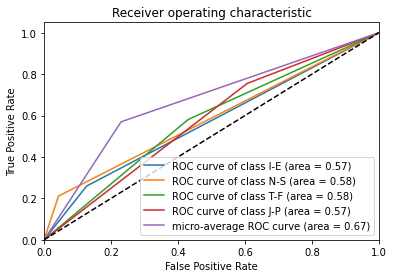

Evaluating Test set..


  0%|          | 0/1735 [00:00<?, ?it/s]

total mbti hits: 372
total accuracy mbti hits: 21.44092219020173
              precision    recall  f1-score   support

         I-E       0.32      0.20      0.25       382
         N-S       0.27      0.11      0.16       246
         T-F       0.60      0.54      0.56       937
         J-P       0.65      0.74      0.69      1066

   micro avg       0.58      0.53      0.55      2631
   macro avg       0.46      0.40      0.41      2631
weighted avg       0.54      0.53      0.53      2631
 samples avg       0.51      0.48      0.47      2631



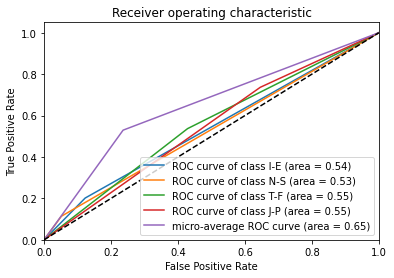

In [51]:
model.eval()
print("Evaluating Validation set..")
evaluate(model, val_sequences)
print("Evaluating Test set..")
evaluate(model, test_sequences)

# Model with Glove Embeddings
Instead of training our own word embeddings, we can use pre-trained Glove word vectors that have been trained on a massive corpus and probably have better context captured.

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
glove_path = 'glove.6B.300d.txt'

--2022-08-04 08:13:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-04 08:13:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-04 08:13:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
def load_glove_vectors(glove_file=glove_path):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

def get_emb_matrix(pretrained, word_counts, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return torch.FloatTensor(W), np.array(vocab), vocab_to_idx

word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [21]:
glove_model = MbtiLSTMNet(input_size=VOCAB_SIZE, 
                   embedding_size=EMBEDDING_SIZE, 
                   hidden_size=HIDDEN_SIZE, output_size=len(LABEL_COLUMNS), 
                   n_layers=N_LAYERS)
glove_model.embedding = nn.Embedding.from_pretrained(pretrained_weights,freeze=True)
glove_model.to(device)
glove_model = train_loop(glove_model, NUM_EPOCHS)

Starting ephoch : 1
Finish Training model on 2000 users for epoch 1
Finish Training model on 4000 users for epoch 1
Finish Training model on 6000 users for epoch 1
Starting ephoch : 2
Finish Training model on 2000 users for epoch 2
Finish Training model on 4000 users for epoch 2
Finish Training model on 6000 users for epoch 2
Starting ephoch : 3
Finish Training model on 2000 users for epoch 3
Finish Training model on 4000 users for epoch 3
Finish Training model on 6000 users for epoch 3
Starting ephoch : 4
Finish Training model on 2000 users for epoch 4
Finish Training model on 4000 users for epoch 4
Finish Training model on 6000 users for epoch 4
Starting ephoch : 5
Finish Training model on 2000 users for epoch 5
Finish Training model on 4000 users for epoch 5
Finish Training model on 6000 users for epoch 5
Starting ephoch : 6
Finish Training model on 2000 users for epoch 6
Finish Training model on 4000 users for epoch 6
Finish Training model on 6000 users for epoch 6
Starting ephoch 

In [23]:
# save the model
GLOVE_MODEL_PATH = '/drive/MyDrive/Colab Notebooks/LSTM_trained_model_glove.pt'
torch.save(glove_model, GLOVE_MODEL_PATH)

Evaluating Validation set..


  0%|          | 0/693 [00:00<?, ?it/s]

total mbti hits: 196
total accuracy mbti hits: 28.28282828282828
              precision    recall  f1-score   support

         I-E       0.42      0.32      0.36       158
         N-S       0.55      0.23      0.33        90
         T-F       0.63      0.67      0.65       377
         J-P       0.66      0.80      0.72       416

   micro avg       0.62      0.63      0.62      1041
   macro avg       0.57      0.50      0.52      1041
weighted avg       0.61      0.63      0.61      1041
 samples avg       0.56      0.55      0.53      1041



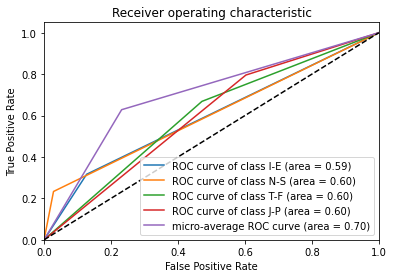

Evaluating Test set..


  0%|          | 0/1735 [00:00<?, ?it/s]

total mbti hits: 389
total accuracy mbti hits: 22.420749279538903
              precision    recall  f1-score   support

         I-E       0.32      0.20      0.24       382
         N-S       0.37      0.13      0.20       246
         T-F       0.59      0.67      0.63       937
         J-P       0.64      0.75      0.69      1066

   micro avg       0.58      0.58      0.58      2631
   macro avg       0.48      0.44      0.44      2631
weighted avg       0.55      0.58      0.56      2631
 samples avg       0.53      0.53      0.50      2631



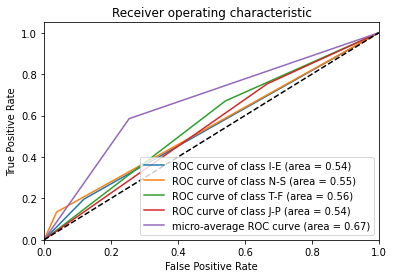

In [49]:
glove_model.eval()
print("Evaluating Validation set..")
evaluate(glove_model, val_sequences)
print("Evaluating Test set..")
evaluate(glove_model, test_sequences)